In [48]:
import logging
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import time
import sklearn.metrics
from utils.checkpoint import CheckPointer
from utils.logger import setup_logger
from trainer import do_train
from train import *

from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from torch import nn

from DatasetLoader import DatasetLoader
from Unet2D import Unet2D

from decouple import config

from PIL import Image, ImageOps
import SimpleITK as sitk


450


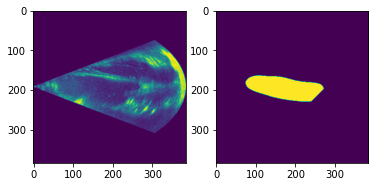

In [50]:
 bs = 12

#epochs
epochs_val = 50

#learning rate
learn_rate = 0.01

base_path = Path(TTE_BASE_PATH)
# data = DatasetLoader(base_path/'train_gray', 
#                     base_path/'train_gt')

data = 
print(len(data))

#split the training dataset and initialize the data loaders
train_dataset, valid_dataset = torch.utils.data.random_split(data, (300, 150))
train_data = DataLoader(train_dataset, batch_size=bs, shuffle=True)
valid_data = DataLoader(valid_dataset, batch_size=bs, shuffle=True)

fig, ax = plt.subplots(1,2)
ax[0].imshow(data.open_as_array(149))
ax[1].imshow(data.open_mask(149))
plt.show()



# /home/erling/datasyn-prosjekt/Data/TTE_full/training/patient0001/patient0001_4CH_sequence.raw


In [93]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan

In [182]:
filename = TTE_FULL_BASE_PATH+"/patient0001/patient0001_4CH_ES.mhd"
filename_gt = filename.replace(".mhd", "_gt.mhd")
# reader = sitk.ImageFileReader()
# reader.SetImageIO("MetaImageIO")
# reader.SetFileName(f)
# image = reader.Execute();

(549, 778, 1)


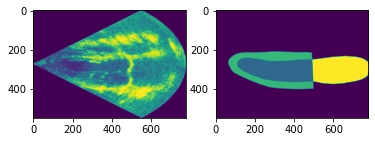

In [185]:
scan = load_itk(filename)
scan_gt = load_itk(filename_gt)
scan = np.transpose(scan)
scan_gt = np.transpose(scan_gt)
print(scan.shape)
fig, ax = plt.subplots(1,2)
ax[0].imshow(Image.fromarray((np.squeeze(scan)), 'L'))
ax[1].imshow(Image.fromarray((np.squeeze(scan_gt)), 'L'))
plt.show()


In [158]:
def combine_files(root, gt_file_name):

    gt_path = os.path.join(root, gt_file_name)
    
    files = {'gt': gt_path, 
            'gray': gt_path.replace("_gt", "")}

    return files

In [164]:
def create_dict(data_dir):
    dict_list=[]
    for root, dirs, files in os.walk(data_dir, topdown=True):
        for name in files:
            if name[-7:] == "_gt.mhd":
                dict_list.append(combine_files(root, name))
    return dict_list

In [165]:
data_dir = TTE_FULL_BASE_PATH
print(data_dir)

new_dict= create_dict(data_dir)
print(new_dict)

Data/TTE_full/training/patient0359/patient0359_2CH_ES_gt.mhd', 'gray': './Data/TTE_full/training/patient0359/patient0359_2CH_ES.mhd'}, {'gt': './Data/TTE_full/training/patient0359/patient0359_2CH_ED_gt.mhd', 'gray': './Data/TTE_full/training/patient0359/patient0359_2CH_ED.mhd'}, {'gt': './Data/TTE_full/training/patient0182/patient0182_4CH_ED_gt.mhd', 'gray': './Data/TTE_full/training/patient0182/patient0182_4CH_ED.mhd'}, {'gt': './Data/TTE_full/training/patient0182/patient0182_4CH_ES_gt.mhd', 'gray': './Data/TTE_full/training/patient0182/patient0182_4CH_ES.mhd'}, {'gt': './Data/TTE_full/training/patient0182/patient0182_2CH_ED_gt.mhd', 'gray': './Data/TTE_full/training/patient0182/patient0182_2CH_ED.mhd'}, {'gt': './Data/TTE_full/training/patient0182/patient0182_2CH_ES_gt.mhd', 'gray': './Data/TTE_full/training/patient0182/patient0182_2CH_ES.mhd'}, {'gt': './Data/TTE_full/training/patient0419/patient0419_2CH_ES_gt.mhd', 'gray': './Data/TTE_full/training/patient0419/patient0419_2CH_ES.mh

In [176]:
print(next(os.walk(TTE_BASE_PATH))[1])

['train_gray', 'train_gt']
